# Predicting the Super Bowl 2022 Winner

## 2. Exploratory Data Analysis

Performance of an NFL team varies throughout the season. Many teams begin strongly and falter as the season progresses (Arizona Cardinals). Some teams struggle in the beginning and improve later (San Francisco 49ers). Some teams may have relatively easier schedule than others, which may inflate their numbers (Dallas Cowboys). Some teams play consistently well but 'peak' before the Super Bowl (Kansas City Chiefs). The teams that consistently play well (Los Angeles Rams) and/or get better as season goes on (Cincinnati Bengals) usually end up as champions.

It is likely that a team's performance (offensive and defensive) is reflection of how well they have performed in the last few games. E.g., the Green Bay Packcers suffered a resounding loss in their first game of this season. However, they ended up with the most wins in NFC by the season end.

Thus, it will be interesting to explore the time-sensitivity of NFL teams' performance.

In [1]:
# Import relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import math

%matplotlib inline
sns.set()

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
# Import data

team_stats = pd.read_csv('SuperBowl_wrangling.csv')
team_stats.head(3)

,Week,Date,Start_Time,Overtime,Home_game,Opponent,Score,Opp_score,1st_downs,Total_yards,Rushing_yards,Turnovers,Opp_1st_downs,Opp_Total_yards,Opp_Rushing_yards,Opp_Turnovers,Team
0,1,2021-09-12,13:00:00,0,1,Pittsburgh Steelers,16,23,22,371,117,1,16,252,75,0,Buffalo Bills
1,2,2021-09-19,13:00:00,0,0,Miami Dolphins,35,0,21,314,143,2,13,223,71,3,Buffalo Bills
2,3,2021-09-26,13:00:00,0,1,Washington Football Team,43,21,29,481,122,0,13,290,78,3,Buffalo Bills


In [3]:
# Rearrange the columns

team_stats.columns.values

array(['Week', 'Date', 'Start_Time', 'Overtime', 'Home_game', 'Opponent',
       'Score', 'Opp_score', '1st_downs', 'Total_yards', 'Rushing_yards',
       'Turnovers', 'Opp_1st_downs', 'Opp_Total_yards',
       'Opp_Rushing_yards', 'Opp_Turnovers', 'Team'], dtype=object)

In [4]:
cols = ['Date', 'Week','Team','Opponent','Home_game','Start_Time', 'Overtime', '1st_downs', 'Total_yards', 'Rushing_yards',
       'Turnovers', 'Opp_1st_downs', 'Opp_Total_yards','Opp_Rushing_yards', 'Opp_Turnovers','Opp_score','Score']

team_stats = team_stats[cols]
team_stats.head(2)

,Date,Week,Team,Opponent,Home_game,Start_Time,Overtime,1st_downs,Total_yards,Rushing_yards,Turnovers,Opp_1st_downs,Opp_Total_yards,Opp_Rushing_yards,Opp_Turnovers,Opp_score,Score
0,2021-09-12,1,Buffalo Bills,Pittsburgh Steelers,1,13:00:00,0,22,371,117,1,16,252,75,0,23,16
1,2021-09-19,2,Buffalo Bills,Miami Dolphins,0,13:00:00,0,21,314,143,2,13,223,71,3,0,35


In [5]:
# Explore data frame by analyzing average statistics per game in NFL 2021 season

team_stats.describe()

,Week,Home_game,Overtime,1st_downs,Total_yards,Rushing_yards,Turnovers,Opp_1st_downs,Opp_Total_yards,Opp_Rushing_yards,Opp_Turnovers,Opp_score,Score
count,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000
mean,9.915493,0.500000,0.080986,20.318662,343.941901,114.649648,1.297535,20.318662,343.941901,114.649648,1.297535,23.038732,23.038732
std,5.580886,0.500441,0.273054,5.058968,85.080884,49.166622,1.191324,5.058968,85.080884,49.166622,1.191324,10.340682,10.340682
min,1.000000,0.000000,0.000000,4.000000,47.000000,-1.000000,0.000000,4.000000,47.000000,-1.000000,0.000000,0.000000,0.000000
25%,5.000000,0.000000,0.000000,17.000000,290.000000,78.750000,0.000000,17.000000,290.000000,78.750000,0.000000,16.000000,16.000000
50%,10.000000,0.500000,0.000000,21.000000,348.500000,106.000000,1.000000,21.000000,348.500000,106.000000,1.000000,23.000000,23.000000
75%,15.000000,1.000000,0.000000,23.000000,398.000000,143.000000,2.000000,23.000000,398.000000,143.000000,2.000000,30.000000,30.000000
max,21.000000,1.000000,1.000000,36.000000,575.000000,273.000000,5.000000,36.000000,575.000000,273.000000,5.000000,56.000000,56.000000


Gamewise statistics in the table above show few interesting observations:

1. About 8% of the total games went into overtime.
2. Teams earned an average of 20 1st downs per game.
3. Teams committed an average of 1 turnover per game. However, they did not commit a turnover in at least 25% of the games.
4. About 1/3rd of total yards covered by teams came from rushing plays.
5. Teams scored an average of 23 points per game, with lowest score of '0' and highest score of '56'.

In [6]:
# Analyze average statistics of each team

team_stats_mean = team_stats.groupby(by='Team', axis=0).mean()
team_stats_mean

,Week,Home_game,Overtime,1st_downs,Total_yards,Rushing_yards,Turnovers,Opp_1st_downs,Opp_Total_yards,Opp_Rushing_yards,Opp_Turnovers,Opp_score,Score
Team,,,,,,,,,,,,,
Arizona Cardinals,9.888889,0.444444,0.000000,21.166667,363.055556,118.722222,0.944444,19.555556,331.777778,116.222222,1.500000,22.222222,25.555556
Atlanta Falcons,9.705882,0.470588,0.000000,18.000000,303.764706,85.352941,1.529412,22.529412,364.352941,131.882353,1.176471,27.000000,18.411765
Baltimore Ravens,9.588235,0.529412,0.235294,23.176471,378.823529,145.823529,1.529412,20.000000,363.411765,84.470588,0.882353,23.058824,22.764706
Buffalo Bills,10.684211,0.526316,0.105263,23.684211,389.315789,131.157895,1.157895,17.631579,289.526316,112.473684,1.684211,18.315789,29.789474
Carolina Panthers,9.294118,0.470588,0.058824,18.941176,298.882353,108.352941,1.705882,18.294118,305.941176,113.823529,0.941176,23.764706,17.882353
Chicago Bears,9.470588,0.470588,0.000000,19.588235,307.352941,118.705882,1.705882,18.882353,316.705882,125.117647,0.941176,23.941176,18.294118
Cincinnati Bengals,11.050000,0.500000,0.200000,19.650000,357.850000,100.300000,1.150000,20.100000,353.850000,106.200000,1.400000,21.750000,26.600000
Cleveland Browns,9.294118,0.529412,0.000000,20.117647,340.647059,145.352941,1.294118,19.235294,311.529412,109.235294,1.117647,21.823529,20.529412
Dallas Cowboys,10.166667,0.500000,0.111111,22.777778,401.444444,122.000000,1.166667,19.333333,350.444444,115.944444,1.944444,21.166667,30.388889


In [7]:
team_stats_mean.iloc[:,-2:]

,Opp_score,Score
Team,,
Arizona Cardinals,22.222222,25.555556
Atlanta Falcons,27.000000,18.411765
Baltimore Ravens,23.058824,22.764706
Buffalo Bills,18.315789,29.789474
Carolina Panthers,23.764706,17.882353
Chicago Bears,23.941176,18.294118
Cincinnati Bengals,21.750000,26.600000
Cleveland Browns,21.823529,20.529412
Dallas Cowboys,21.166667,30.388889


Teamwise statistics show a clear trend among team that qualified for the playoffs:
1. Team offense covers more than 350 yards/per game
2. Their opponents cover less than 20 or more yards per game
3. Teams consistenyl outscore the opponents 

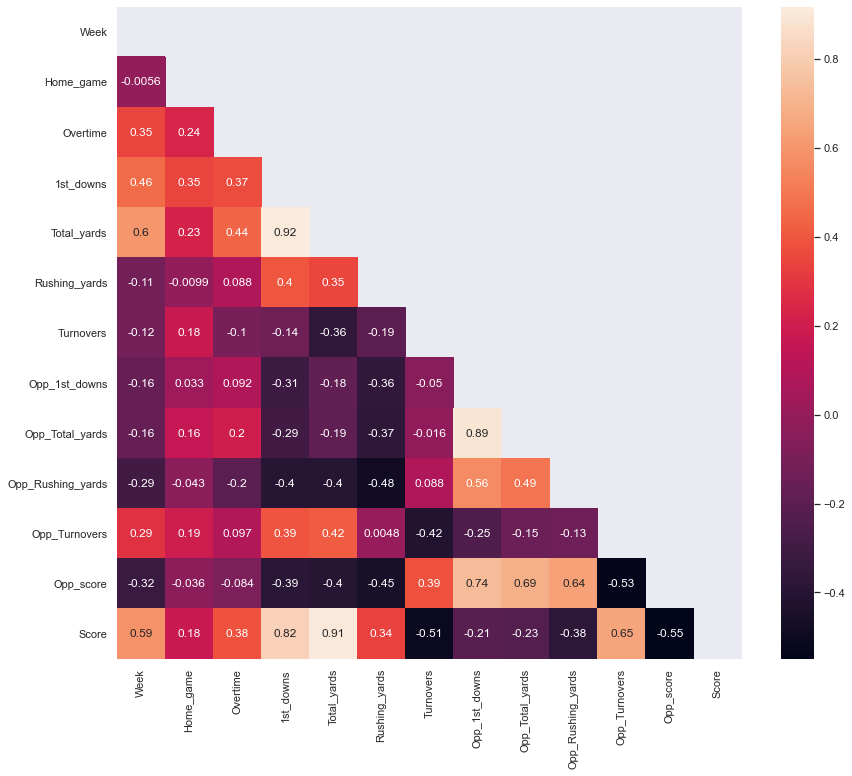

In [8]:
# Analyze correlation between teams' score and other features

plt.figure(figsize=(14,12))
corr = team_stats_mean.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True)
plt.show();

A team's score has significant correlation with the following features in decreasing order:
1. *Total_yards*
2. *1st_downs*
3. *Opp_Turnovers*
4. *Week*
5. *Opp_score*
6. *Turnovers*

Also, 'Week' feature has a significant correlation with *1st_downs* and *Total_yards*. This suggests that teams' performance might have changed as the season progressed. Therefore, a time-series analysis of these feature is necessary before performing regression analysis.

In [9]:
# Check performance of Los Angeles Rams over the season

LAR = team_stats[team_stats.Team == 'Los Angeles Rams']
LAR.set_index('Week', inplace=True)
LAR

,Date,Team,Opponent,Home_game,Start_Time,Overtime,1st_downs,Total_yards,Rushing_yards,Turnovers,Opp_1st_downs,Opp_Total_yards,Opp_Rushing_yards,Opp_Turnovers,Opp_score,Score
Week,,,,,,,,,,,,,,,,
1,2021-09-12,Los Angeles Rams,Chicago Bears,1,20:20:00,0,18,386,74,0,24,322,134,2,14,34
2,2021-09-19,Los Angeles Rams,Indianapolis Colts,0,13:00:00,0,21,371,101,2,22,354,109,2,24,27
3,2021-09-26,Los Angeles Rams,Tampa Bay Buccaneers,1,16:25:00,0,22,407,76,0,27,446,35,0,24,34
4,2021-10-03,Los Angeles Rams,Arizona Cardinals,1,16:05:00,0,24,401,121,2,27,465,216,0,37,20
5,2021-10-07,Los Angeles Rams,Seattle Seahawks,0,20:20:00,0,24,476,118,1,22,354,92,2,17,26
6,2021-10-17,Los Angeles Rams,New York Giants,0,13:00:00,0,22,365,131,2,21,261,60,4,11,38
7,2021-10-24,Los Angeles Rams,Detroit Lions,1,16:05:00,0,22,374,47,0,19,415,137,2,19,28
8,2021-10-31,Los Angeles Rams,Houston Texans,0,13:00:00,0,26,467,165,0,18,323,44,1,22,38
9,2021-11-07,Los Angeles Rams,Tennessee Titans,1,20:20:00,0,22,347,94,2,16,194,69,1,28,16


In [10]:
# Create a list of features that we will investigate for time-dependency

col_list = ['1st_downs','Total_yards','Rushing_yards','Opp_1st_downs','Opp_Total_yards','Opp_Rushing_yards']

In [46]:
# Write a function to plot specified features for a given team

def plot_features(data, col_list):
    
    fig, axs = plt.subplots(3, 2, figsize=(12,16))
    
    for feature, ax in zip(col_list, axs.ravel()):
        data[feature].plot(ax=ax)
        ax.set_title(feature)
        ax.set_xlabel('Week')
        ax.set_xticks(np.arange(0,22,2))
    
    plt.show()

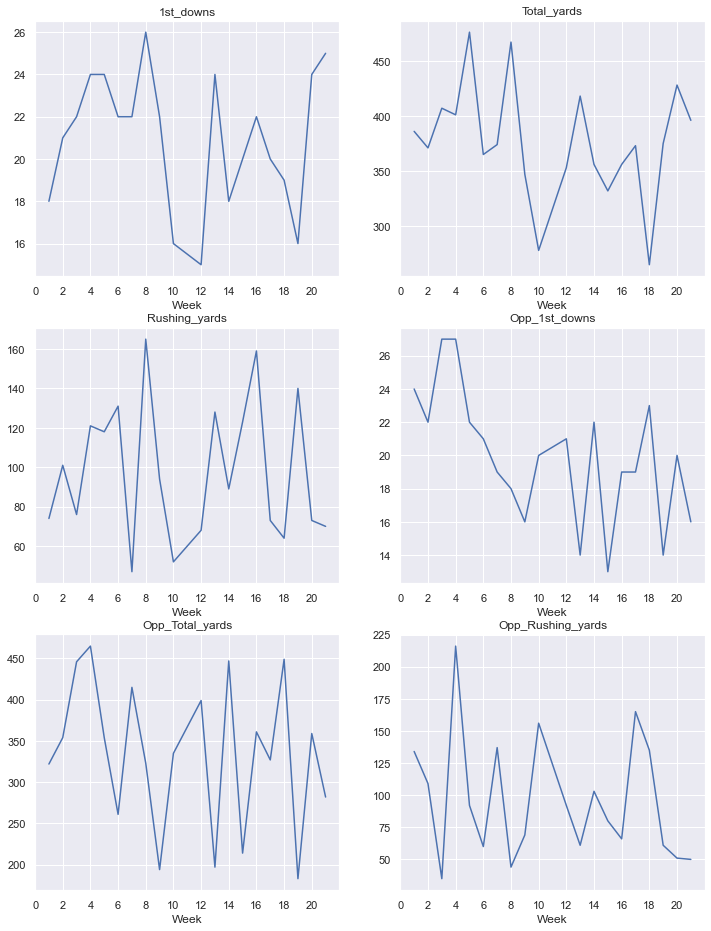

In [47]:
# Plot selected feature for LAR

plot_features(LAR, col_list)

In [13]:
# Run augmented Dickey-Fuller test to check stationarity

for feature in col_list:
    results = adfuller(LAR[feature])
    print(f'The p-value for {feature} feature is : {round(results[1],3)}')

The p-value for 1st_downs feature is : 0.079
The p-value for Total_yards feature is : 0.044
The p-value for Rushing_yards feature is : 0.004
The p-value for Opp_1st_downs feature is : 0.0
The p-value for Opp_Total_yards feature is : 0.509
The p-value for Opp_Rushing_yards feature is : 0.019


The Null Hypothesis for 'adfuller' test is that the series is non-stationary. If p < 0.05, we can reject the hypothesis and consider the series as stationary.

Therefore, *'Total_yards', 'Rushing_yards', 'Opp_1st_downs',* and *'Opp_Rushing_yards'* are stationary features for the Rams (p < 0.05). *'1st_downs* and *'Opp_Total_yards'* are the non-stationary features (p > 0.05).

In [14]:
# 1st_downs

LAR_1st_downs_diff = LAR['1st_downs'].diff().dropna()
results = adfuller(LAR_1st_downs_diff)
print(f'p-value:{round(results[1],3)}')

p-value:0.0


In [15]:
# 'Opp_Total_yards'

LAR_Opp_Total_yards_diff = LAR['Opp_Total_yards'].diff().dropna()
results = adfuller(LAR_Opp_Total_yards_diff)
print(f'p-value:{round(results[1],3)}')

p-value:0.0


In [16]:
# Convert the remaining features of LAR into pandas series

LAR_Total_yards = LAR['Total_yards']
LAR_Rushing_yards = LAR['Rushing_yards']
LAR_Opp_1st_downs = LAR['Opp_1st_downs']
LAR_Opp_Rushing_yards = LAR['Opp_Rushing_yards']

In [36]:
# Plot autocorrelation and partial autocorrelation functions

def plot_corr_func(series):
    fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,8))
    
    plot_acf(series, lags=8, zero=False, ax=ax1)
    
    plot_pacf(series, lags=8, zero=False, ax=ax2)

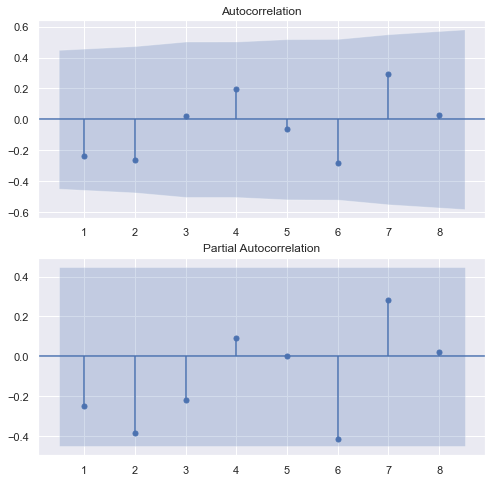

In [37]:
# Plot ACF and PACF for LAR 1st_down

plot_corr_func(LAR_1st_downs_diff)

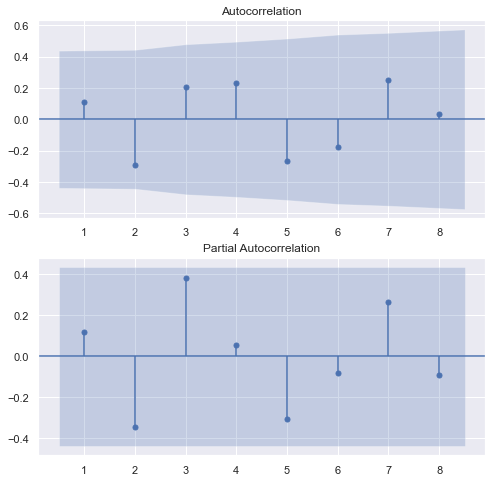

In [38]:
# Plot ACF and PACF for LAR Total_yards

plot_corr_func(LAR_Total_yards)

Both *1st_down* and *Total_yards* features do not show statistically significant correlation for the Los Angeles Rams.

In [20]:
# Check performance of Cincinnati Bengals over the season

CIN = team_stats[team_stats.Team == 'Cincinnati Bengals']
CIN.set_index('Week', inplace=True)
CIN

,Date,Team,Opponent,Home_game,Start_Time,Overtime,1st_downs,Total_yards,Rushing_yards,Turnovers,Opp_1st_downs,Opp_Total_yards,Opp_Rushing_yards,Opp_Turnovers,Opp_score,Score
Week,,,,,,,,,,,,,,,,
1,2021-09-12,Cincinnati Bengals,Minnesota Vikings,1,13:00:00,1,20,366,149,0,24,403,67,1,24,27
2,2021-09-19,Cincinnati Bengals,Chicago Bears,0,13:00:00,0,14,248,69,4,16,206,123,1,20,17
3,2021-09-26,Cincinnati Bengals,Pittsburgh Steelers,0,13:00:00,0,12,268,96,1,21,342,45,2,10,24
4,2021-09-30,Cincinnati Bengals,Jacksonville Jaguars,1,20:20:00,0,21,420,78,0,21,341,139,0,21,24
5,2021-10-10,Cincinnati Bengals,Green Bay Packers,1,13:00:00,1,18,367,103,2,21,466,133,1,25,22
6,2021-10-17,Cincinnati Bengals,Detroit Lions,0,13:00:00,0,20,398,142,1,15,228,36,1,11,34
7,2021-10-24,Cincinnati Bengals,Baltimore Ravens,0,13:00:00,0,19,520,111,1,20,393,115,0,17,41
8,2021-10-31,Cincinnati Bengals,New York Jets,0,13:00:00,0,18,318,41,1,32,511,97,3,34,31
9,2021-11-07,Cincinnati Bengals,Cleveland Browns,1,13:00:00,0,25,348,85,3,14,361,153,0,41,16


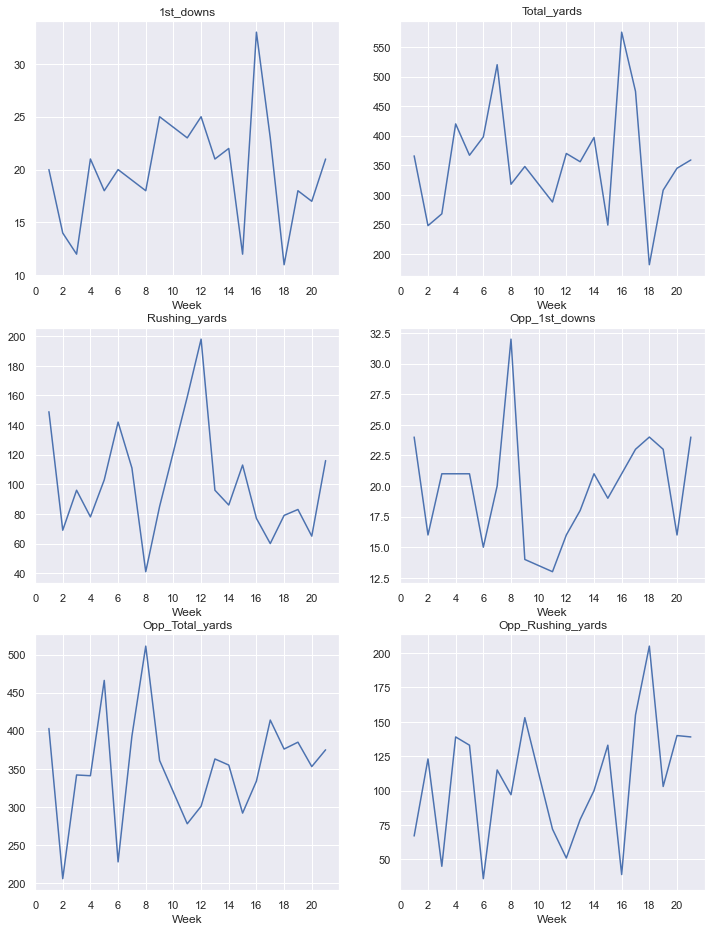

In [48]:
# Plot selected feature for CIN

plot_features(CIN, col_list)

In [22]:
# Run augmented Dickey-Fuller test to check stationarity

for feature in col_list:
    results = adfuller(CIN[feature])
    print(f'The p-value for {feature} feature is : {round(results[1],3)}')

The p-value for 1st_downs feature is : 0.0
The p-value for Total_yards feature is : 0.772
The p-value for Rushing_yards feature is : 0.0
The p-value for Opp_1st_downs feature is : 0.0
The p-value for Opp_Total_yards feature is : 0.665
The p-value for Opp_Rushing_yards feature is : 0.404


In [26]:
# Total_yards

CIN_Total_yards_diff = CIN['Total_yards'].diff().diff().diff().dropna()
results = adfuller(CIN_Total_yards_diff)
print(f'p-value:{round(results[1],3)}')

p-value:0.004


In [29]:
# Opp_Total_yards

CIN_Opp_Total_yards_diff = CIN['Opp_Total_yards'].diff().diff().dropna()
results = adfuller(CIN_Opp_Total_yards_diff)
print(f'p-value:{round(results[1],3)}')

p-value:0.0


In [32]:
# Opp_Rushing_yards

CIN_Opp_Rushing_yards_diff = CIN['Opp_Rushing_yards'].diff().diff().dropna()
results = adfuller(CIN_Opp_Rushing_yards_diff)
print(f'p-value:{round(results[1],3)}')

p-value:0.0


In [33]:
# Convert the remaining features of CIN into pandas series

CIN_1st_downs = CIN['1st_downs']
CIN_Rushing_yards = CIN['Rushing_yards']
CIN_Opp_1st_downs = CIN['Opp_1st_downs']

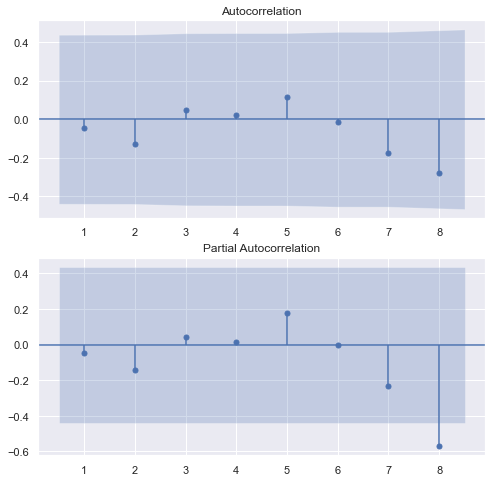

In [39]:
# Plot ACF and PACF for CIN 1st_downs

plot_corr_func(CIN_1st_downs)

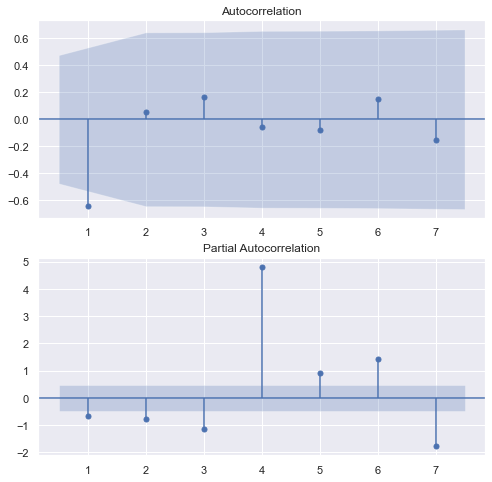

In [35]:
# Plot ACF and PACF for CIN Total_yards

plot_corr_func(CIN_Total_yards_diff)

The changes in *'Total_yards'* covered by Cincinnati Bengals correlate with time.

Since each team played a maximum of 20 games in the current season, we may not have enough data to perform reliable statistical analysis. Let's check if using the entire data frame solves this issue.

In [40]:
# Change the data frame index to a time-dependent feature ('Week')

team_stats_weekly = team_stats.set_index('Week',drop=True)
team_stats_weekly_grouped = team_stats_weekly.groupby(by='Week').mean()

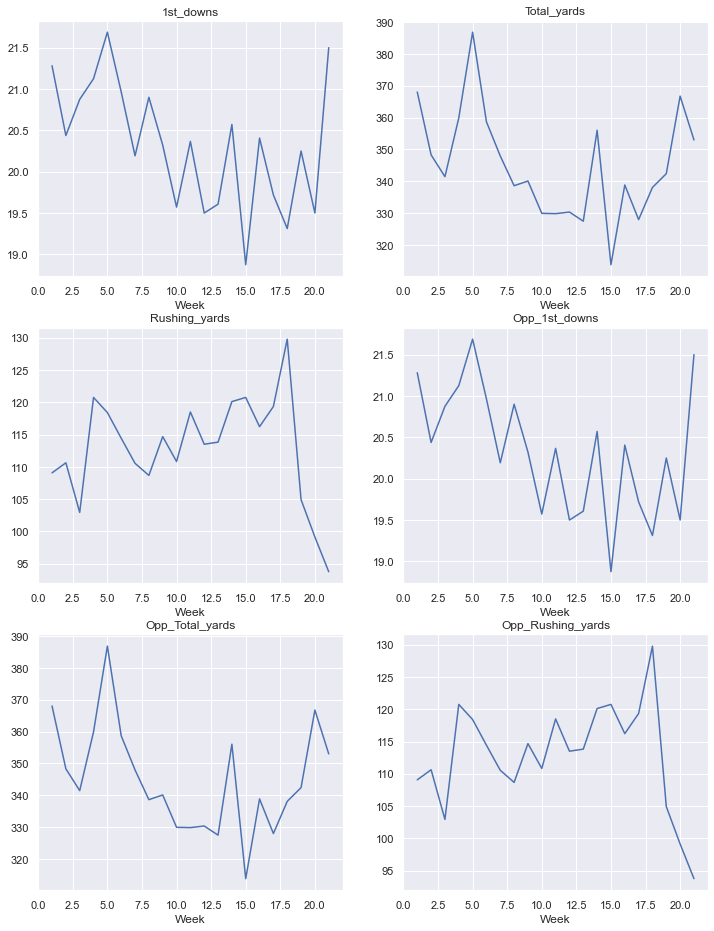

In [41]:
# Plot selected feature for team_stats_weekly

plot_features(team_stats_weekly_grouped, col_list)

In [49]:
# Run augmented Dickey-Fuller test to check stationarity

for feature in col_list:
    results = adfuller(team_stats_weekly_grouped[feature])
    print(f'The p-value for {feature} feature is : {round(results[1],3)}')

The p-value for 1st_downs feature is : 0.01
The p-value for Total_yards feature is : 0.029
The p-value for Rushing_yards feature is : 0.927
The p-value for Opp_1st_downs feature is : 0.01
The p-value for Opp_Total_yards feature is : 0.029
The p-value for Opp_Rushing_yards feature is : 0.927


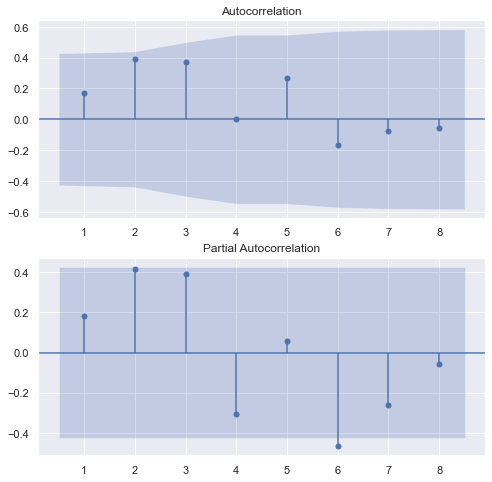

In [50]:
# Plot ACF and PACF for CIN 1st_downs

plot_corr_func(team_stats_weekly_grouped['1st_downs'])

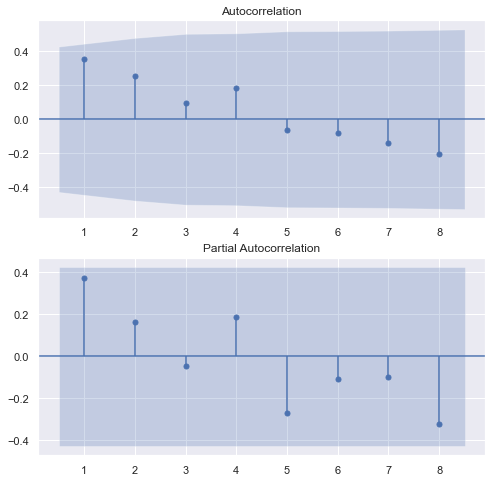

In [51]:
# Plot ACF and PACF for 'Total_yards'

plot_corr_func(team_stats_weekly_grouped['Total_yards'])

*'1st_downs'* and *'Total_yards* features do not show statistically significant correlation. Therefore, following another approach for data modeling is necessary.